###Trying SVC & Log-LassoClassifiers:

In [216]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [185]:
#this data set has: i) candidate info; ii) movable assets; iii) immovable assets
assets_df=pd.read_csv("assets_df.csv")

In [186]:
assets_df.drop('Unnamed: 0_x', axis=1, inplace=True)
assets_df.drop('Unnamed: 0', axis=1, inplace=True)
assets_df.drop('Unnamed: 0.1', axis=1, inplace=True)

In [187]:
assets_df.head(1)

,"Bonds, Debentures and Shares in companies",Cash,"Deposits in Banks, Financial Institutions and Non-Banking Financial Companies",Gross Total Value (as per Affidavit),Jewellery (give details weight value),LIC or other insurance Policies,"Motor Vehicles (details of make, etc.)","NSS, Postal Savings etc","Other assets, such as values of claims / interests",Personal loans/advance given,TOTAL_MOVABLE_ASSESTS,Totals (Calculated as Sum of Values),url,year_x,winner,location,state,Age,Assets_Rs,Constituency,Criminal_Cases,Education,Liabilities_Rs,Link,Name,Party,State,Agricultural Land,Commercial Buildings,Non Agricultural Land,Others,Residential Buildings,TOTAL_IMMOVABLE_ASSESTS,Total Current Market Value of (i) to (v) (as per Affidavit),year_y
0,NaN,70500,1519565,NaN,128501,350000,410000,316155,621439,NaN,3416160,3066160,http://myneta.info/loksabha2004/candidate.php?...,2004,1,Andaman & Nicobar Islands (ANDAMAN & NICOBAR ...,ANDAMAN & NICOBAR ISLANDS,65,5926740,Andaman & Nicobar Islands,0,Post Graduate,272061,candidate.php?candidate_id=1,MANORANJAN BHAKTA,INC,ANDAMAN & NICOBAR ISLANDS,846000,NaN,64580,NaN,1950000,2860580,NaN,2004


#####Step 1: Log-transform income data

In [188]:
assets_df=assets_df.replace(np.NaN,0.0)

In [204]:
assets_df=assets_df.replace('NATIONAL CAPITAL TERRITORY OF DELHI','DELHI')

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/pandas/core/common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [205]:
#list(assets_df.columns)

In [206]:
logcols=list(assets_df.columns)
non_assest=('Gross Total Value (as per Affidavit)','url','year_x','winner','location','state','Age',
            'Assets_Rs','Constituency','Criminal_Cases','Education','Liabilities_Rs','Link','Name','Party','State','year_y',
            'Total Current Market Value of (i) to (v) (as per Affidavit)','Totals (Calculated as Sum of Values)')

In [207]:
for i in non_assest:
    try:
        logcols.remove(i)
    except:
        print i
print len(logcols)

16


Remove observations with zero total assets. 
Treat tables where immovable assets=0 as missing data since it's not credible that candidates have zero cash; they must have avoided reporting altogether...

In [226]:
#remove tables where total assests report including cash=0
nonempty=assets_df[(assets_df['TOTAL_MOVABLE_ASSESTS']!=0)]
count_nonempty=len(nonempty.TOTAL_MOVABLE_ASSESTS)
count_all=len(assets_df.TOTAL_MOVABLE_ASSESTS)
print count_all-count_nonempty

2155


In [227]:
#log transofrm asset info:
for st in logcols:
    nonempty[st]=np.log(nonempty[st]+1)

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#####Step 2: Standardize all the columns
In this step all the features will be normalized with zero mean and unit standard deviation.

In [228]:
categorical = ['Constituency','Education','Party','State']
for c in categorical:
    le = LabelEncoder().fit(nonempty[c])
    nonempty[c]=le.transform(nonempty[c])

/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [229]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(nonempty.shape[0]), train_size=0.8)

In [238]:
mask=np.ones(nonempty.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [239]:
#list(nonempty.columns)

In [241]:
%%time
dftrain=nonempty[mask]

numeric = logcols + ['Criminal_Cases']

std_scale = StandardScaler().fit(dftrain[numeric])
#enc = OneHotEncoder().fit(dftrain['Education'])

nonempty[numeric] = std_scale.transform(nonempty[numeric])
#categorical_vars = enc.transform(nonempty['Education']).toarray()

#standarized = []
#for x,y in zip(numeric_vars, categorical_vars):
#    standarized.append(np.concatenate([x,y]))
#    std_df = pd.DataFrame(standarized)

#std_df.head(1)

CPU times: user 3.47 s, sys: 46.8 ms, total: 3.52 s
Wall time: 4.11 s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


####Classifiers

#####SVM Classifier:

We test out support vector machine learning for our asymmetric data set. As SVMs work best with rather balanced data sets, we will sub-sample our data in the next section of this notebook.

In [242]:
from sklearn.svm import SVC

In [243]:
clfsvm=SVC()
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=nonempty[numeric].values
Yresp=nonempty['winner'].values

In [244]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [340]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, make_scorer
from sklearn.grid_search import GridSearchCV

In [353]:
def cv_optimize(clf, parameters, X, y, n_folds=5):
    
    #NOTES (TRANSFER TO MARKDOWN LATER):
    #created option to add different types of scorers for cross-validation:
    #here, i use 'roc_auc_score' because of the high asymmetry in our dataset.
    
    score_fx=make_scorer(roc_auc_score,greater_is_better=True)
    
    #added scoring component to GridSearch
    #change scoring to 'None' for standard accuracy within grid search:
    
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_fx)
    gs.fit(X, y)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

#code help from hw3

In [ ]:

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test__accuracy = clf.score(Xtest, ytest)
    print "Based on standard predict::"
    print "  Accuracy on training data: %0.2f" % (training_accuracy)
    print "  Acurracy on test data:     %0.2f" % (test__accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "_______________________________"
    return clf, Xtrain, ytrain, Xtest, ytest

#code from hw3
# removed scoring function option in both functions and embedded it make_scorer feature wth roc_auc_scorer

In [352]:
%%time
#THIS ONE IS USING ACCURACY WITHIN THE GRIDSEARCH:
#DO NOT RERUN- SCORING ADJUSTED IN FUNCTION INVARIABLY!

#tried class class_weights={1:10}; results = same as before; didnt' work
#tried class class_weights='auto'; results = same as before; didnt' work
#adding gamma parameter options; gamma refers to the length of the maximum margin between the hyperplane and support vectors
#(C is inversely related to the "leniency" of the classifier)

clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), 
                                                   {"C": [ 10, 1, 0.1, 0.01,0.001,0.0001,0.00001 ]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.92
  Acurracy on test data:     0.93
[[3146    0]
 [ 250    0]]
_______________________________
CPU times: user 1min 53s, sys: 2.15 s, total: 1min 55s
Wall time: 2min 7s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [346]:
%%time
#THIS ONE IS USING ROC_AUC_SCORER WITHIN GRIDSEARCH:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(), 
                                                   {"C": [ 100,20,15,10, 1, 0.1, 0.01,0.001,0.0001]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 10}
Based on standard predict::
  Accuracy on training data: 0.94
  Acurracy on test data:     0.91
[[3088   58]
 [ 231   19]]
_______________________________
CPU times: user 2min 2s, sys: 2.31 s, total: 2min 4s
Wall time: 2min 26s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [355]:
%%time
#try with class-weight:
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(SVC(class_weight='auto'), 
                                                   {"C": [ 100,20,15,10, 1, 0.1, 0.01,0.001,0.0001]}, 
                                                   nonempty,featurenames=logcols, targetname='winner',target1val=1, mask=mask)

using mask
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.74
  Acurracy on test data:     0.73
[[2264  882]
 [  37  213]]
_______________________________
CPU times: user 7min 41s, sys: 8.6 s, total: 7min 50s
Wall time: 8min 29s


/Users/anneshrestha/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(array([ 410.,  400.,  404.,  412.,  352.,  323.,  330.,  381.,  305.,   79.]),
 array([ 0.22904636,  0.305041  ,  0.38103564,  0.45703029,  0.53302493,
         0.60901957,  0.68501422,  0.76100886,  0.8370035 ,  0.91299815,
         0.98899279]),
 <a list of 10 Patch objects>)

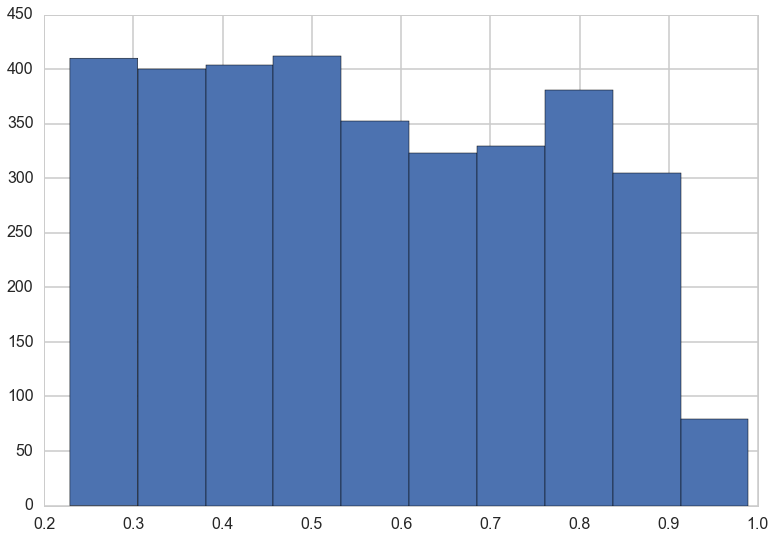

In [302]:
plt.hist(clfsvm.decision_function(Xtest))

In [282]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [356]:
print "whole data set", nonempty['winner'].mean()
print "training set", nonempty['winner'][mask].mean(), "test set", nonempty['winner'][~mask].mean()

whole data set 0.0774486129925
training set 0.0784068320695 test set 0.0736160188457


In [357]:
#set different thresholds
def t_repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred
#from hw3

In [361]:
for p in [0.1,0.2,0.4,0.5,0.8]:
    print "Threshold of ", p, ":  "
    print confusion_matrix(ytest,t_repredict(clflog, p, Xtest))

Threshold of  0.1 :  
[[   0 3146]
 [   0  250]]
Threshold of  0.2 :  
[[3145    1]
 [ 250    0]]
Threshold of  0.4 :  
[[3146    0]
 [ 250    0]]
Threshold of  0.5 :  
[[3146    0]
 [ 250    0]]
Threshold of  0.8 :  
[[3146    0]
 [ 250    0]]


#####Log-Lasso Classifier:
penalty l1 = lasso regularization

In [362]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty="l1")
parameters = {"C": [0.01,0.001,0.0001,0.00001,0.000001,0.0000001, 0.1, 1, 10, 100]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clf,parameters, nonempty,logcols, 'winner',0, reuse_split=reuse_split)


using reuse split
BEST PARAMS {'C': 10}
Based on standard predict::
  Accuracy on training data: 0.92
  Acurracy on test data:     0.92
[[3116   30]
 [ 240   10]]
_______________________________


([array([  0.00000000e+00,   1.00000000e+00,   7.00000000e+00,
           1.60000000e+01,   1.60000000e+01,   4.10000000e+01,
           8.70000000e+01,   1.89000000e+02,   4.07000000e+02,
           2.63200000e+03]),
  array([  2.63200000e+03,   4.07000000e+02,   1.89000000e+02,
           8.70000000e+01,   4.10000000e+01,   1.60000000e+01,
           1.60000000e+01,   7.00000000e+00,   1.00000000e+00,
           0.00000000e+00])],
 array([  9.78358612e-04,   1.00782687e-01,   2.00587015e-01,
          3.00391343e-01,   4.00195672e-01,   5.00000000e-01,
          5.99804328e-01,   6.99608657e-01,   7.99412985e-01,
          8.99217313e-01,   9.99021641e-01]),
 <a list of 2 Lists of Patches objects>)

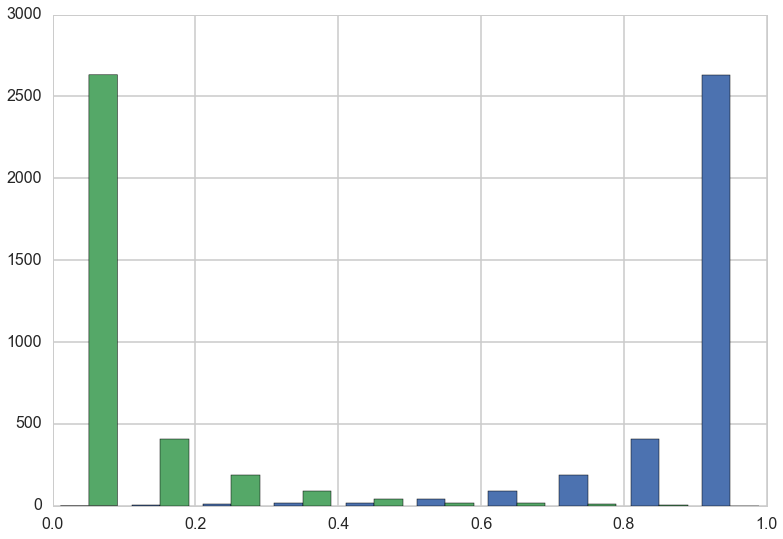

In [364]:
plt.hist(clflog.predict_proba(Xtest))

###### ROC curves:
Write Code:

##### Running the two classifiers on a balanced train set:

In [158]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

1273 14034


In [257]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [258]:
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(2546,)

In [175]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((5092, 16), (5092,))

In [176]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [177]:
clflog_b, _,_,_,_  = do_classify(clf, {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_new)

using reuse split
BEST PARAMS {'C': 10.0}
Based on standard predict::
  Accuracy on training data: 0.80
  Accuracy on test data:     0.87
[[3208  317]
 [ 165  137]]
-


In [172]:
clfsvm_b, _,_,_,_  = do_classify(SVC(), {"C": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, nonempty,logcols, 'winner',1, reuse_split=reuse_split_new)

using reuse split
BEST PARAMS {'C': 0.1}
Based on standard predict::
  Accuracy on training data: 0.80
  Accuracy on test data:     0.81
[[2901  624]
 [  87  215]]
-
